# AutoEncoder

In [1]:
import tensorflow.keras as k
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from data_util import *

## Hyper parameters

In [2]:
input_shape = (28, 28)
hidden_unit = 128
batch_size = 128
noise_factor = 0.3
epochs = 5
num_classes = 10
cmap = "Greys"

## Dataset

In [3]:
(x_train, y_train), (x_test, y_test) = load_mnist()

x_train: (60000, 28, 28)
y_train: (60000, 10)
x_test: (10000, 28, 28)
y_test: (10000, 10)


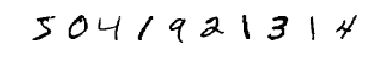

In [4]:
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)
show_mnist(x_train[:10])

## Model --- Denoising Autoencoder

### AutoEncoder = Encoder + Decoder

In [7]:
dae_conv = k.models.load_model('models/dae_conv_noise9.h5')
dae_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 128)               324288    
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28)            325121    
Total params: 649,409
Trainable params: 649,409
Non-trainable params: 0
_________________________________________________________________


## Reconstruct Data

In [8]:
x_train_noisy = np.concatenate([sap_noise(x_train, level/10) for level in range(4,9)])

In [9]:
x_train_denoisy = dae_conv.predict(x_train_noisy)

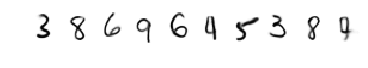

In [16]:
show_mnist(x_train_denoisy[290000:290010])

### Save Data

In [15]:
np.save('x_train_denoisy.npy', x_train_denoisy)

### Load Data

In [4]:
x_train_denoisy = np.load('x_train_denoisy.npy')

### Generate Labels

In [5]:
y_train_denoisy = np.concatenate([y_train for _ in range(5)])

## Model --- Conv NN with BN layer

### Model with BN and unnormalized data

In [6]:
conv_nn = k.models.Sequential(layers=[
    Reshape((28,28,1), input_shape=(28,28)),
    Conv2D(32, kernel_size = 3, activation='relu'),
    BatchNormalization(),
    Conv2D(32, kernel_size = 3, activation='relu'),
    BatchNormalization(),
    Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Conv2D(64, kernel_size = 3, activation='relu'),
    BatchNormalization(),
    Conv2D(64, kernel_size = 3, activation='relu'),
    BatchNormalization(),
    Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Conv2D(128, kernel_size = 4, activation='relu'),
    BatchNormalization(),
    Flatten(),
    Dropout(0.4),
    Dense(10, activation='softmax'),
])

In [7]:
conv_nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 32)        128       
__________

### compile and train

In [8]:
conv_nn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [10]:
conv_nn.fit(x_train_denoisy, y_train_denoisy, batch_size=256, epochs=10, shuffle=True)

Epoch 1/10
300000/300000 [==============================] - 43s 142us/step - loss: 0.0391 - acc: 0.9869
Epoch 2/10
300000/300000 [==============================] - 43s 142us/step - loss: 0.0383 - acc: 0.9872
Epoch 3/10
300000/300000 [==============================] - 43s 143us/step - loss: 0.0370 - acc: 0.9877
Epoch 4/10
300000/300000 [==============================] - 43s 143us/step - loss: 0.0361 - acc: 0.9878
Epoch 5/10
300000/300000 [==============================] - 43s 143us/step - loss: 0.0351 - acc: 0.9883
Epoch 6/10
300000/300000 [==============================] - 43s 143us/step - loss: 0.0341 - acc: 0.9885
Epoch 7/10
300000/300000 [==============================] - 43s 143us/step - loss: 0.0335 - acc: 0.9888
Epoch 8/10
300000/300000 [==============================] - 43s 145us/step - loss: 0.0324 - acc: 0.9889
Epoch 9/10
300000/300000 [==============================] - 43s 144us/step - loss: 0.0323 - acc: 0.9890
Epoch 10/10
300000/300000 [==============================] - 43s

In [11]:
def evaluate_acc(model):
    hists = []
    for i in range(10):
        noise_level = i / 10
        x_test_noise = sap_noise(x_test, noise_level)
        hist = model.evaluate(x_test_noise, y_test, verbose=0)
        title = "noise level:" + str(noise_level) + "\tAccuracy:" + str(hist[1])
        hists.append(hist)
    hists = np.array(hists)
    return hists

Text(0.5, 1.0, 'Predict with Gauusian Noise')

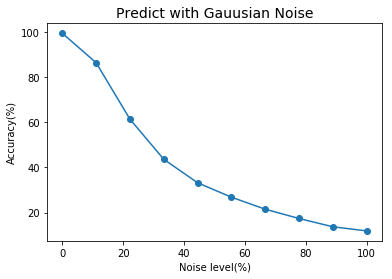

In [14]:
conv_nn_acc = evaluate_acc(conv_nn)
plt.plot(np.linspace(0,100,num=10),conv_nn_acc[:,1]*100, "-o")
plt.xlabel('Noise level(%)')
plt.ylabel('Accuracy(%)')
plt.title("Predict with Gauusian Noise", fontsize=14)

### Save Model

In [13]:
conv_nn.save("models/conv_nn.h5")

In [5]:
conv_nn = k.models.load_model("models/conv_nn.h5")

## Denoise and Classify Model


**Predict Process:** Image + Noise ==> Denoise Autoencoer ==> NN classifier  

**Note** : 
- The Denoise Autoencoder and NN classifier are Trained **separated**.
- The NN classifier has BatchNormailize Layer.
- The data is **NOT** Normalized before train this classifier.

In [8]:
x_input  = k.layers.Input((28,28), name = "Model_Input")
dae_nn_conv = Model(x_input, conv_nn(dae_conv(x_input)), name="denoiseclassifier")
dae_nn_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Model_Input (InputLayer)     (None, 28, 28)            0         
_________________________________________________________________
autoencoder (Model)          (None, 28, 28)            649409    
_________________________________________________________________
sequential (Sequential)      (None, 10)                327242    
Total params: 976,651
Trainable params: 975,819
Non-trainable params: 832
_________________________________________________________________


In [9]:
dae_nn_conv.compile(loss = "categorical_crossentropy",
                  optimizer="adam",
                  metrics = ['accuracy'],
                  )

### Save Model

In [16]:
dae_nn_conv.save('models/dae_nn_conv.h5')

### Predict with Noise

In [12]:
dae_nn_conv_acc = evaluate_acc(dae_nn_conv)

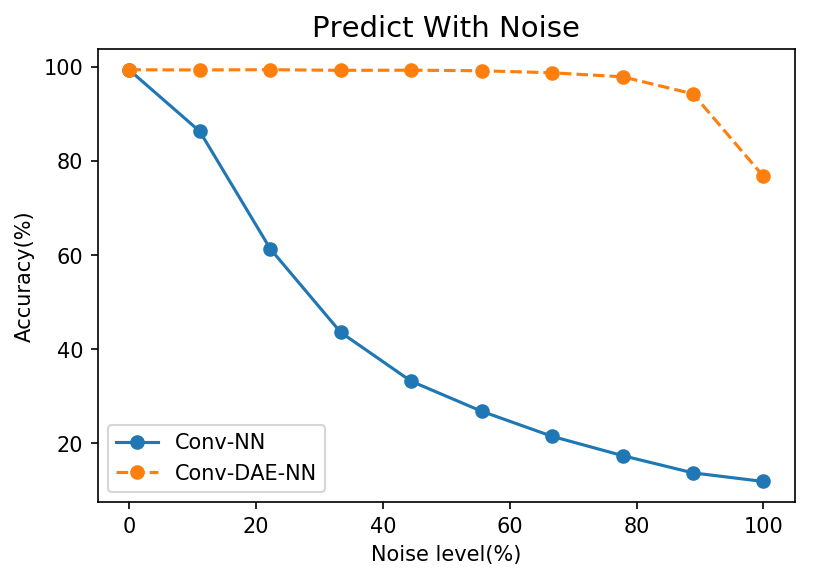

In [15]:
plt.figure(dpi=150)
plt.plot(np.linspace(0,100,num=10),conv_nn_acc[:,1]*100, "-o", label="Conv-NN")
plt.plot(np.linspace(0,100,num=10),dae_nn_conv_acc[:,1]*100, "--o", label ="Conv-DAE-NN")
plt.xlabel('Noise level(%)')
plt.ylabel('Accuracy(%)')
plt.title("Predict With Noise", fontsize=14)
plt.legend()